# Imports


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.naive_bayes import GaussianNB
import csv
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing as pre
from sklearn import impute
from sklearn.pipeline import Pipeline 

import pandas as pd
import scipy.sparse as sp
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import time


# KNN Data Set

In [4]:
knnData = pd.read_csv('./data/train_transaction_clean.csv')
knnDf = pd.DataFrame(knnData)

ynn = list(knnDf.isFraud)
knn = knnDf.drop(columns=['TransactionID', 'isFraud'])
xnn_train, xnn_test, ynn_train, ynn_test = train_test_split(knn, ynn, test_size=0.2, random_state=0)

print(knn.shape)


(590540, 378)


## PCA new data

In [14]:
scaler = StandardScaler()
scaler.fit(xnn_test)
scaled_data = scaler.transform(xnn_test)
pca = PCA(n_components=250)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)

print(scaled_data.shape)
print(x_pca.shape)
print(pca.explained_variance_ratio_.sum())

print("\n")

pcaVisual = PCA(n_components=3)
pcaVisual.fit(scaled_data)
visualX = pcaVisual.transform(scaled_data)

print(scaled_data.shape)
print(visualX.shape)
print(pcaVisual.explained_variance_ratio_.sum())

(118108, 378)
(118108, 250)
0.9948601493607527


(118108, 378)
(118108, 3)
0.3153893085017755


# Testing new data

### Helper Functions

In [71]:
def pw4(y_pred):
    isC0 = np.equal(y_pred,0) * 1
    isC1 = np.equal(y_pred,1) * 1
    isC2 = np.equal(y_pred,2) * 1
    isC3 = np.equal(y_pred,3) * 1
    #count of isFraud found in each cluster
    count0 = np.sum(np.logical_and(y_test,isC0)) 
    count1 = np.sum(np.logical_and(y_test,isC1))
    count2 = np.sum(np.logical_and(y_test,isC2))
    count3 = np.sum(np.logical_and(y_test,isC3))
    countArray = np.array([count0, count1, count2, count3])

    #size of each cluster
    size0 = np.sum(isC0)
    size1 = np.sum(isC1)
    size2 = np.sum(isC2)
    size3 = np.sum(isC3)
    sizeArray = np.array([size0, size1, size2, size3])

    #fraction of fraud in each cluster
    f0 = count0 / size0
    f1 = count1 / size1
    f2 = count2/ size2
    f3 = count3 / size3
    fractionArray = np.array([f0,f1,f2,f3])

    fraudIndex = np.argmax(fractionArray[np.logical_not(np.isnan(fractionArray))])
    #For every array, swap fraud to index 0
    temp = countArray[0]
    countArray[0] = countArray[fraudIndex]
    countArray[fraudIndex] = temp

    temp = sizeArray[0]
    sizeArray[0] = sizeArray[fraudIndex]
    sizeArray[fraudIndex] = temp

    temp = fractionArray[0]
    fractionArray[0] = fractionArray[fraudIndex]
    fractionArray[fraudIndex] = temp

    TP = countArray[0]
    TN = sizeArray[1] + sizeArray[2] + sizeArray[3] - countArray[1] - countArray[2] - countArray[3]
    FP = sizeArray[0] - countArray[0]
    FN = countArray[1] + countArray[2] + countArray[3]
    N = TP+TN+FP+FN
    return TP,TN,FP,FN,N

def pw2(y_pred):
    isC0 = np.equal(y_pred,0) * 1
    isC1 = np.equal(y_pred,1) * 1
    #count of isFraud found in each cluster
    count0 = np.sum(np.logical_and(y_test,isC0)) 
    count1 = np.sum(np.logical_and(y_test,isC1))
    countArray = np.array([count0, count1])
    #size of each cluster
    size0 = np.sum(isC0)
    size1 = np.sum(isC1)
    
    sizeArray = np.array([size0, size1])
    #fraction of fraud in each cluster
    f0 = count0 / size0
    f1 = count1 / size1
    fractionArray = np.array([f0,f1])
    fraudIndex = np.argmax(fractionArray)
    #For every array, swap fraud to index 0
    temp = countArray[0]
    countArray[0] = countArray[fraudIndex]
    countArray[fraudIndex] = temp

    temp = sizeArray[0]
    sizeArray[0] = sizeArray[fraudIndex]
    sizeArray[fraudIndex] = temp

    temp = fractionArray[0]
    fractionArray[0] = fractionArray[fraudIndex]
    fractionArray[fraudIndex] = temp

    TP = countArray[0]
    TN = sizeArray[1] - countArray[1]
    FP = sizeArray[0] - countArray[0]
    FN = countArray[1]
    N = TP+TN+FP+FN
    return TP,TN,FP,FN,N
    
def getMaxCluster(y_pred):
    isC0 = np.equal(y_pred,0) * 1
    isC1 = np.equal(y_pred,1) * 1
    isC2 = np.equal(y_pred,2) * 1
    isC3 = np.equal(y_pred,3) * 1
    #count of isFraud found in each cluster
    count0 = np.sum(np.logical_and(y_test,isC0)) 
    count1 = np.sum(np.logical_and(y_test,isC1))
    count2 = np.sum(np.logical_and(y_test,isC2))
    count3 = np.sum(np.logical_and(y_test,isC3))
    countArray = np.array([count0, count1, count2, count3])

    #size of each cluster
    size0 = np.sum(isC0)
    size1 = np.sum(isC1)
    size2 = np.sum(isC2)
    size3 = np.sum(isC3)
    sizeArray = np.array([size0, size1, size2, size3])

    #fraction of fraud in each cluster
    f0 = count0 / size0
    f1 = count1 / size1
    f2 = count2/ size2
    f3 = count3 / size3
    fractionArray = np.array([f0,f1,f2,f3])

    return np.argmax(fractionArray[np.logical_not(np.isnan(fractionArray))])



In [23]:
#Loop through number of features, test kmeans, gmm once at every level of feature
scaler = StandardScaler()
scaler.fit(xnn_test)
scaled_data = scaler.transform(xnn_test)

kPrecision = np.zeros(16)
kRecall = np.zeros(16)
kF = np.zeros(16)
kBalanced = np.zeros(16)
kRS = np.zeros(16)
kJC = np.zeros(16)

gmm2Precision = np.zeros(16)
gmm2Recall = np.zeros(16)
gmm2F = np.zeros(16)
gmm2Balanced = np.zeros(16)
gmm2RS = np.zeros(16)
gmm2JC = np.zeros(16)


gmm4Precision = np.zeros(16)
gmm4Recall = np.zeros(16)
gmm4F = np.zeros(16)
gmm4Balanced = np.zeros(16)
gmm4RS = np.zeros(16)
gmm4JC = np.zeros(16)


index = 0
for numFeatures in range(1, 379, 25):
    print(numFeatures)
    for numTimes in range(3):
        #pca the data
        pca = PCA(n_components=numFeatures)
        pca.fit(scaled_data)
        x_pca = pca.transform(scaled_data)
        #fit, predict each model
        kmeans = KMeans(n_clusters=2, init='k-means++', n_init='auto').fit(x_pca)
        kmeansY = kmeans.predict(x_pca)
        gmm2 = GaussianMixture(n_components=2, init_params='k-means++').fit(x_pca)
        gmm2Y = gmm2.predict(x_pca)
        gmm4 = GaussianMixture(n_components=4, init_params='k-means++').fit(x_pca)
        gmm4Y = gmm4.predict(x_pca)
        #PW Each Model
        gmm4TP, gmm4TN, gmm4FP, gmm4FN, gmm4N = pw4(gmm4Y)
        gmm2TP, gmm2TN, gmm2FP, gmm2FN, gmm2N = pw2(gmm2Y)
        kTP, kTN, kFP, kFN, kN = pw2(kmeansY)

        kPrecision[index] += kTP/(kTP+kFP)
        kRecall[index] += kTP / (kTP+kFN)
        kF[index] += kPrecision[index] * kRecall[index] / (kPrecision[index] + kRecall[index])
        kBalanced[index] += 0.5 * (kTP/(kTP + kFN) + kTN/(kTN + kFP))
        kRS[index] += (kTP + kTN)/kN
        kJC[index] += kTP/(kTP+kFN+kFP)


        gmm2Precision[index] += gmm2TP/(gmm2TP+gmm2FP)
        gmm2Recall[index] += gmm2TP / (gmm2TP+gmm2FN)
        gmm2F[index] += gmm2Precision[index] * gmm2Recall[index] / (gmm2Precision[index] + gmm2Recall[index])
        gmm2Balanced[index] += 0.5 * (gmm2TP/(gmm2TP + gmm2FN) + gmm2TN/(gmm2TN + gmm2FP))
        gmm2RS[index] += (gmm2TP + gmm2TN)/gmm2N
        gmm2JC[index] += gmm2TP/(gmm2TP+gmm2FN+gmm2FP)


        gmm4Precision[index] += gmm4TP/(gmm4TP+gmm4FP)
        gmm4Recall[index] += gmm4TP / (gmm4TP+gmm4FN)
        gmm4F[index] += gmm4Precision[index] * gmm4Recall[index] / (gmm4Precision[index] + gmm4Recall[index])
        gmm4Balanced[index] += 0.5 * (gmm4TP/(gmm4TP + gmm4FN) + gmm4TN/(gmm4TN + gmm4FP))
        gmm4RS[index] += (gmm4TP + gmm4TN)/gmm4N
        gmm4JC[index] += gmm4TP/(gmm4TP+gmm4FN+gmm4FP)
    index += 1

kPrecision /= 3
kRecall /= 3
kF /= 3
kBalanced /= 3
kRS /= 3
kJC /= 3


gmm2Precision /= 3
gmm2Recall /= 3
gmm2F /= 3
gmm2Balanced /= 3
gmm2RS /= 3
gmm2JC /= 3


gmm4Precision /= 3
gmm4Recall /= 3
gmm4F /= 3
gmm4Balanced /= 3
gmm4RS /= 3
gmm4JC /= 3

1
26
51
76
101
126
151
176
201
226
251
276
301
326
351


/Users/keyeseames/anaconda3/envs/ml_hw1/lib/python3.11/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


376


In [28]:
hoAxis = np.arange(1,379,25)

# Evaluation of K Means

Text(0.5, 1.0, 'k-means Jaccard Coefficient')

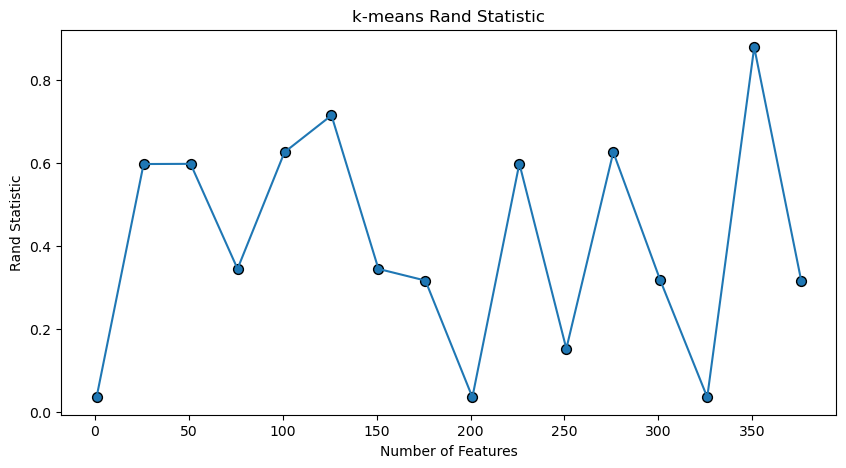

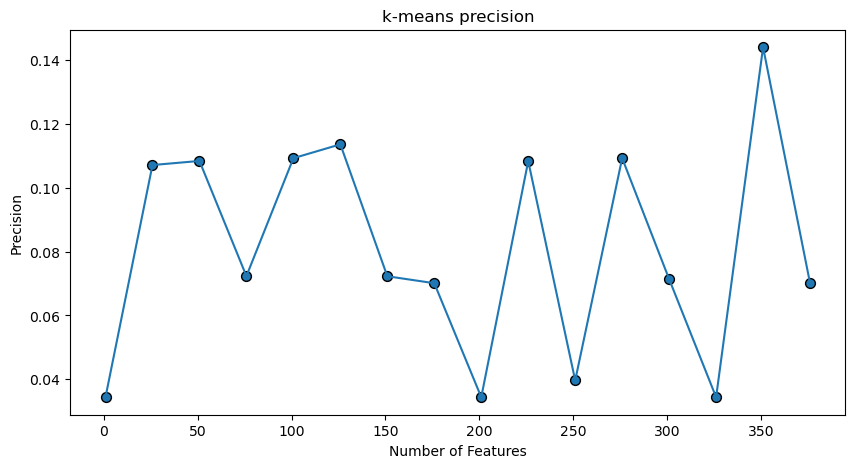

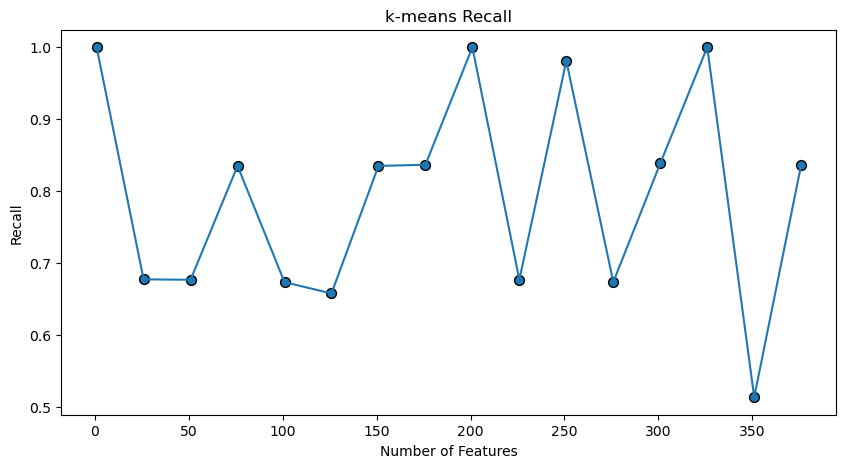

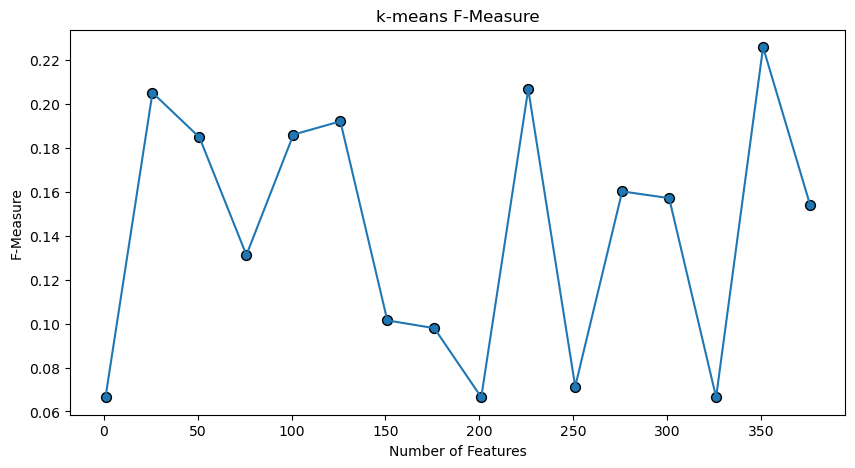

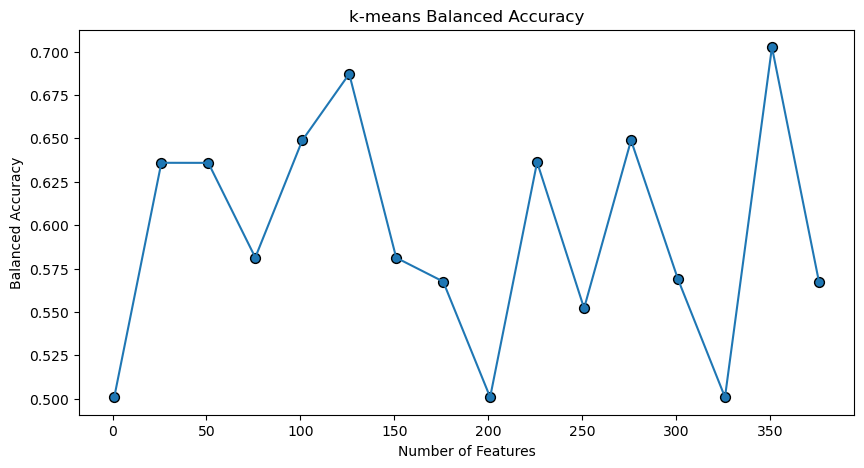

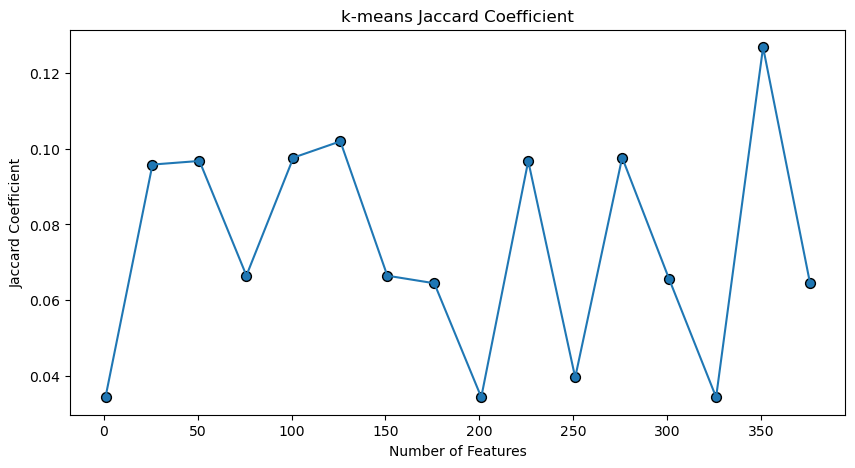

In [37]:
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, kRS, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, kRS)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Rand Statistic")
ax.set_title("k-means Rand Statistic")

fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, kPrecision, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, kPrecision)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Precision")
ax.set_title("k-means precision")

fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, kRecall, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, kRecall)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Recall")
ax.set_title("k-means Recall")


fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, kF, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, kF)
ax.set_xlabel("Number of Features")
ax.set_ylabel("F-Measure")
ax.set_title("k-means F-Measure")



fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, kBalanced, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, kBalanced)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Balanced Accuracy")
ax.set_title("k-means Balanced Accuracy")

fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, kJC, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, kJC)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Jaccard Coefficient")
ax.set_title("k-means Jaccard Coefficient")



In [49]:
temp = np.max(kPrecision)
print("The maximum precision was", temp)
temp = np.max(kRecall[1:])
print("The maximum nontrivial recall was", temp)
temp = np.max(kF)
print("The maximum F-measure was", temp)
temp = np.max(kBalanced)
print("The maximum balanced accuracy was", temp)
temp = np.max(kRS)
print("The maximum Rand Statistic was", temp)
temp = np.max(kJC)
print("The maximum Jaccard Coefficient was", temp)

The maximum precision was 0.144104954684957
The maximum nontrivial recall was 1.0
The maximum F-measure was 0.22593040211115945
The maximum balanced accuracy was 0.7025322885673452
The maximum Rand Statistic was 0.8786788363193009
The maximum Jaccard Coefficient was 0.12678931702928314


In [50]:
temp = np.average(kPrecision)
print("The average precision was", temp)
temp = np.average(kRecall)
print("The average nontrivial recall was", temp)
temp = np.average(kF)
print("The average F-measure was", temp)
temp = np.average(kBalanced)
print("The average balanced accuracy was", temp)
temp = np.average(kRS)
print("The average Rand Statistic was", temp)
temp = np.average(kJC)
print("The average Jaccard Coefficient was", temp)

The average precision was 0.08121261333162635
The average nontrivial recall was 0.794463639355051
The average F-measure was 0.14213478641416957
The average balanced accuracy was 0.5948143120496936
The average Rand Statistic was 0.40886395643535295
The average Jaccard Coefficient was 0.07396458893559882


In [52]:
temp = np.var(kPrecision)
print("The variance of precision was", temp)
temp = np.var(kRecall[1:])
print("The variance of recall was", temp)
temp = np.var(kF)
print("The variance of F-measure was", temp)
temp = np.var(kBalanced)
print("The variance of balanced accuracy was", temp)
temp = np.var(kRS)
print("The variance of Rand Statistic was", temp)
temp = np.var(kJC)
print("The variance of Jaccard Coefficient was", temp)

The variance of precision was 0.0010970897985804725
The variance of recall was 0.019571141381436116
The variance of F-measure was 0.003003925125974639
The variance of balanced accuracy was 0.0038655116777762226
The variance of Rand Statistic was 0.06445432444213228
The variance of Jaccard Coefficient was 0.0007785682444513382


# Evaluation of GMM With 2 Clusters

Text(0.5, 1.0, 'gmm2 Jaccard Coefficient')

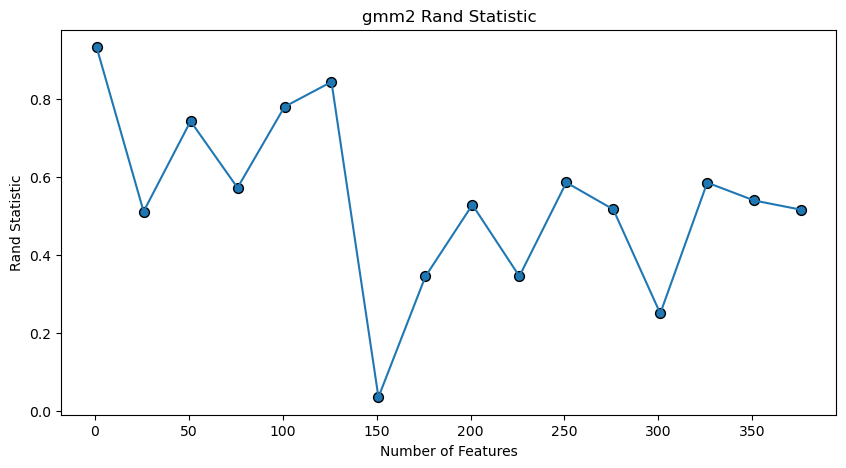

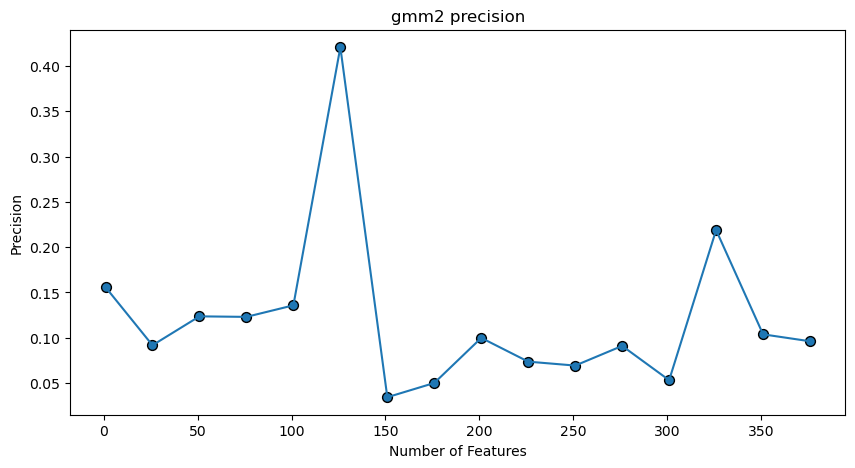

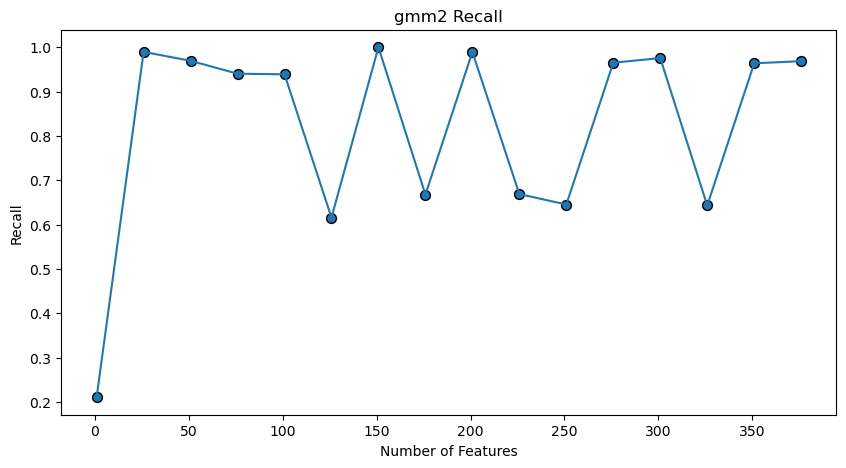

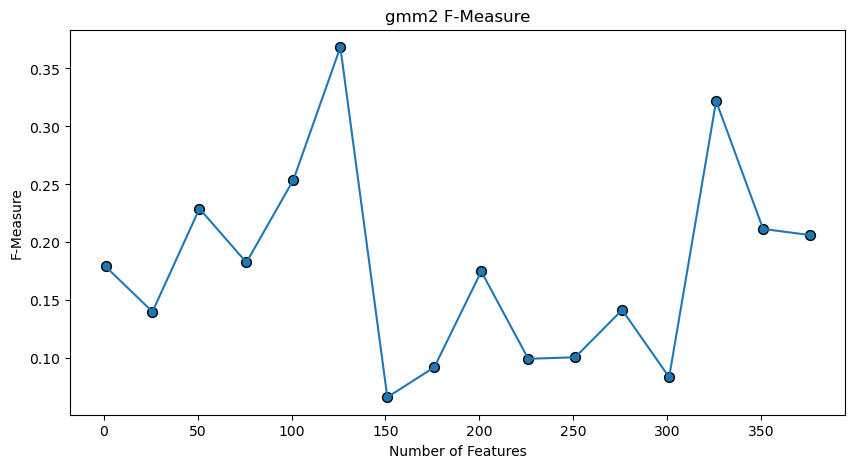

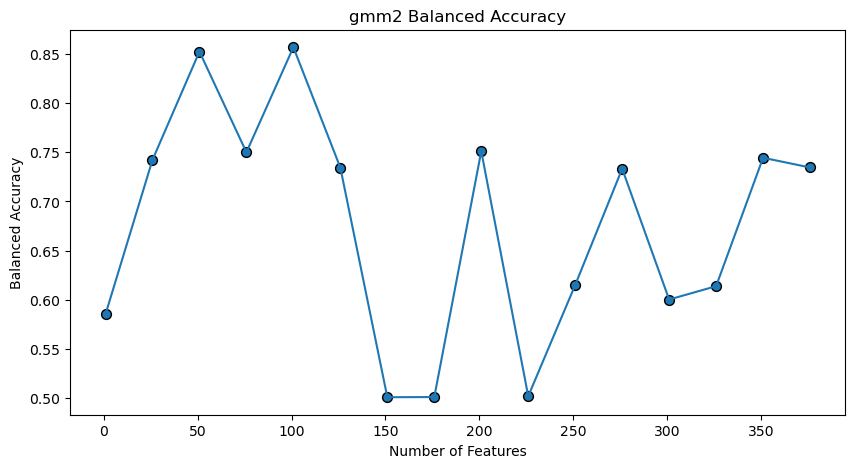

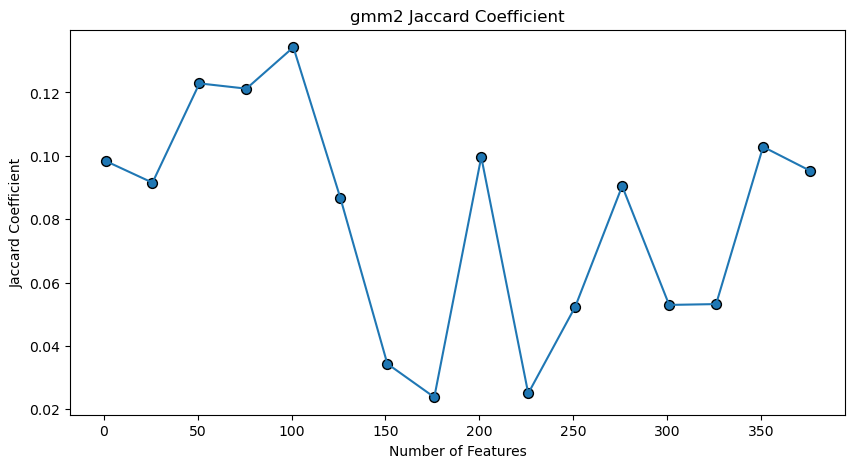

In [53]:
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, gmm2RS, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, gmm2RS)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Rand Statistic")
ax.set_title("gmm2 Rand Statistic")

fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, gmm2Precision, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, gmm2Precision)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Precision")
ax.set_title("gmm2 precision")

fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, gmm2Recall, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, gmm2Recall)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Recall")
ax.set_title("gmm2 Recall")


fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, gmm2F, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, gmm2F)
ax.set_xlabel("Number of Features")
ax.set_ylabel("F-Measure")
ax.set_title("gmm2 F-Measure")



fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, gmm2Balanced, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, gmm2Balanced)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Balanced Accuracy")
ax.set_title("gmm2 Balanced Accuracy")

fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, gmm2JC, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, gmm2JC)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Jaccard Coefficient")
ax.set_title("gmm2 Jaccard Coefficient")


In [54]:
temp = np.max(gmm2Precision)
print("The maximum precision was", temp)
temp = np.max(gmm2Recall)
print("The maximum nontrivial recall was", temp)
temp = np.max(gmm2F)
print("The maximum F-measure was", temp)
temp = np.max(gmm2Balanced)
print("The maximum balanced accuracy was", temp)
temp = np.max(gmm2RS)
print("The maximum Rand Statistic was", temp)
temp = np.max(gmm2JC)
print("The maximum Jaccard Coefficient was", temp)

The maximum precision was 0.4206589544113941
The maximum nontrivial recall was 1.0
The maximum F-measure was 0.3683439337800756
The maximum balanced accuracy was 0.8570950238722842
The maximum Rand Statistic was 0.9337668348742959
The maximum Jaccard Coefficient was 0.13429401742542615


In [55]:
temp = np.average(gmm2Precision)
print("The average precision was", temp)
temp = np.average(gmm2Recall)
print("The average nontrivial recall was", temp)
temp = np.average(gmm2F)
print("The average F-measure was", temp)
temp = np.average(gmm2Balanced)
print("The average balanced accuracy was", temp)
temp = np.average(gmm2RS)
print("The average Rand Statistic was", temp)
temp = np.average(gmm2JC)
print("The average Jaccard Coefficient was", temp)

The average precision was 0.12127929258849637
The average nontrivial recall was 0.8219654902928595
The average F-measure was 0.1782690991246151
The average balanced accuracy was 0.676037027691846
The average Rand Statistic was 0.5401214707442905
The average Jaccard Coefficient was 0.08029835293847773


In [56]:
temp = np.var(gmm2Precision)
print("The variance of precision was", temp)
temp = np.var(gmm2Recall[1:])
print("The variance of recall was", temp)
temp = np.var(gmm2F)
print("The variance of F-measure was", temp)
temp = np.var(gmm2Balanced)
print("The variance of balanced accuracy was", temp)
temp = np.var(gmm2RS)
print("The variance of Rand Statistic was", temp)
temp = np.var(gmm2JC)
print("The variance of Jaccard Coefficient was", temp)

The variance of precision was 0.007875198952676306
The variance of recall was 0.02339069916394899
The variance of F-measure was 0.006926899482834054
The variance of balanced accuracy was 0.012995553494615234
The variance of Rand Statistic was 0.048065479324030005
The variance of Jaccard Coefficient was 0.0011711701870239307


# Evaluation of GMM With 4 Clusters

Text(0.5, 1.0, 'gmm4 Jaccard Coefficient')

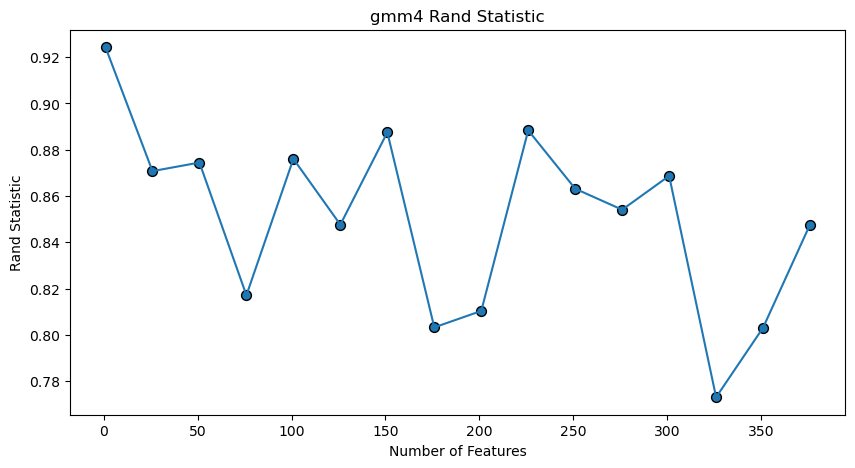

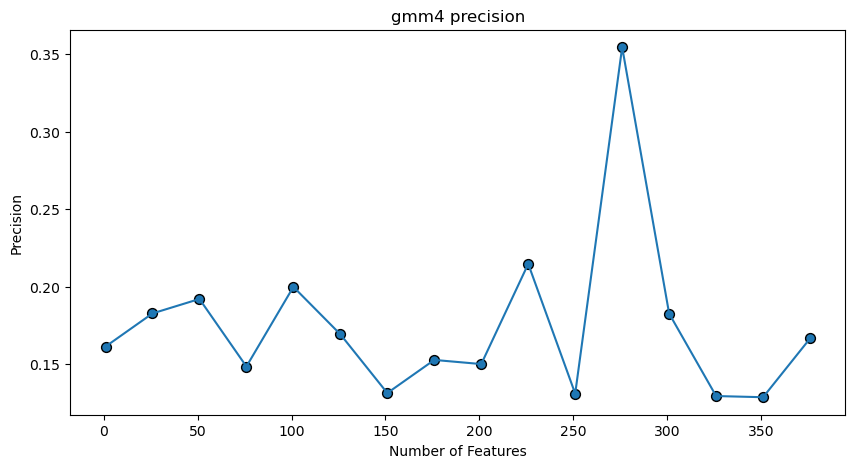

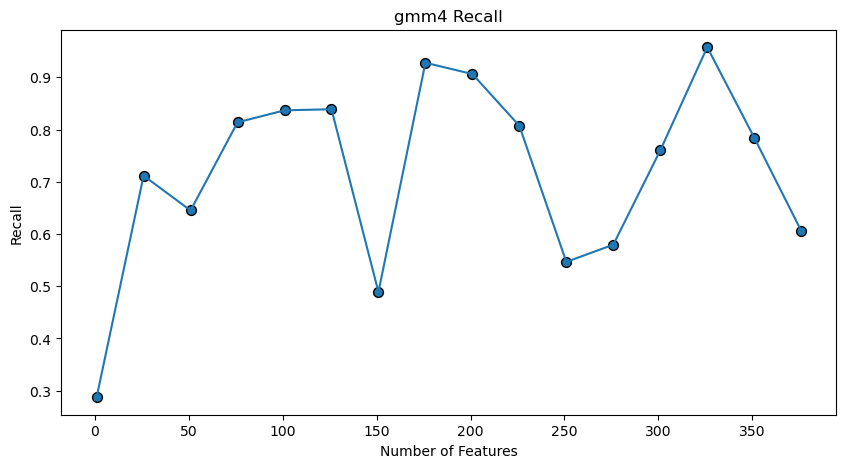

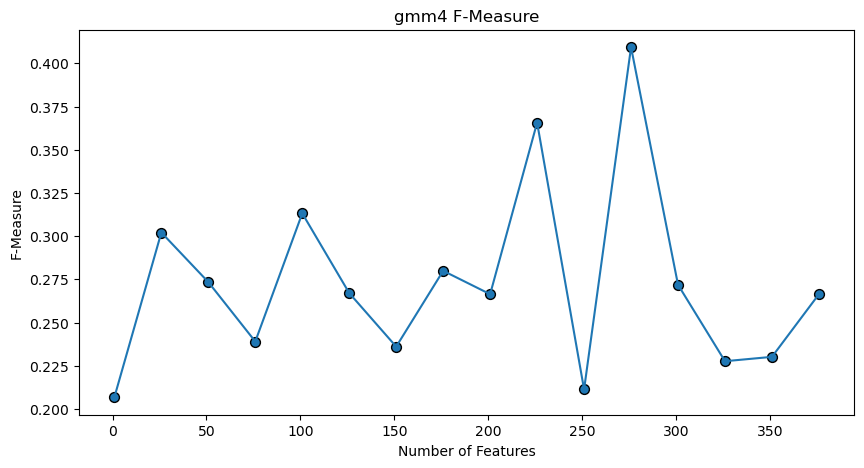

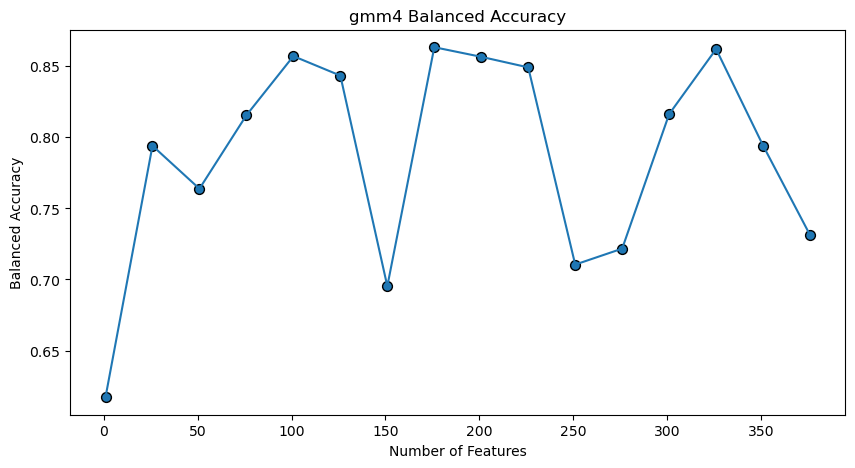

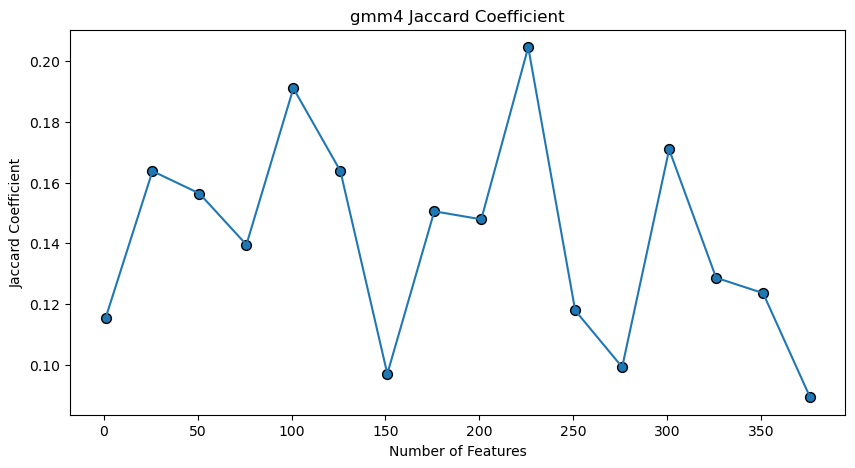

In [57]:
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, gmm4RS, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, gmm4RS)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Rand Statistic")
ax.set_title("gmm4 Rand Statistic")

fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, gmm4Precision, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, gmm4Precision)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Precision")
ax.set_title("gmm4 precision")

fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, gmm4Recall, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, gmm4Recall)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Recall")
ax.set_title("gmm4 Recall")


fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, gmm4F, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, gmm4F)
ax.set_xlabel("Number of Features")
ax.set_ylabel("F-Measure")
ax.set_title("gmm4 F-Measure")



fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, gmm4Balanced, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, gmm4Balanced)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Balanced Accuracy")
ax.set_title("gmm4 Balanced Accuracy")

fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, gmm4JC, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, gmm4JC)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Jaccard Coefficient")
ax.set_title("gmm4 Jaccard Coefficient")


In [58]:
temp = np.max(gmm4Precision)
print("The maximum precision was", temp)
temp = np.max(gmm4Recall)
print("The maximum nontrivial recall was", temp)
temp = np.max(gmm4F)
print("The maximum F-measure was", temp)
temp = np.max(gmm4Balanced)
print("The maximum balanced accuracy was", temp)
temp = np.max(gmm4RS)
print("The maximum Rand Statistic was", temp)
temp = np.max(gmm4JC)
print("The maximum Jaccard Coefficient was", temp)

The maximum precision was 0.3545824671492192
The maximum nontrivial recall was 0.9575518262586377
The maximum F-measure was 0.40934587585040766
The maximum balanced accuracy was 0.8633567987119725
The maximum Rand Statistic was 0.9242698772874545
The maximum Jaccard Coefficient was 0.20466383288558912


In [59]:
temp = np.average(gmm4Precision)
print("The average precision was", temp)
temp = np.average(gmm4Recall)
print("The average nontrivial recall was", temp)
temp = np.average(gmm4F)
print("The average F-measure was", temp)
temp = np.average(gmm4Balanced)
print("The average balanced accuracy was", temp)
temp = np.average(gmm4RS)
print("The average Rand Statistic was", temp)
temp = np.average(gmm4JC)
print("The average Jaccard Coefficient was", temp)

The average precision was 0.17469504502073635
The average nontrivial recall was 0.7186266041461007
The average F-measure was 0.27288535168075334
The average balanced accuracy was 0.786966439566913
The average Rand Statistic was 0.8506171258509161
The average Jaccard Coefficient was 0.14120623854141373


In [60]:
temp = np.var(gmm4Precision)
print("The variance of precision was", temp)
temp = np.var(gmm4Recall[1:])
print("The variance of recall was", temp)
temp = np.var(gmm4F)
print("The variance of F-measure was", temp)
temp = np.var(gmm4Balanced)
print("The variance of balanced accuracy was", temp)
temp = np.var(gmm4RS)
print("The variance of Rand Statistic was", temp)
temp = np.var(gmm4JC)
print("The variance of Jaccard Coefficient was", temp)

The variance of precision was 0.0028156385561919
The variance of recall was 0.019654864805858454
The variance of F-measure was 0.0027774320303210207
The variance of balanced accuracy was 0.005065326914713624
The variance of Rand Statistic was 0.0014741063091969955
The variance of Jaccard Coefficient was 0.0010572850853899347


# Data Visualization

In [61]:
scaler = StandardScaler()
scaler.fit(xnn_test)
scaled_data = scaler.transform(xnn_test)
vpca = PCA(n_components=125)
vpca.fit(scaled_data)
v_pca = pca.transform(scaled_data)
print(vpca.explained_variance_ratio_.sum())


0.9517112771154634


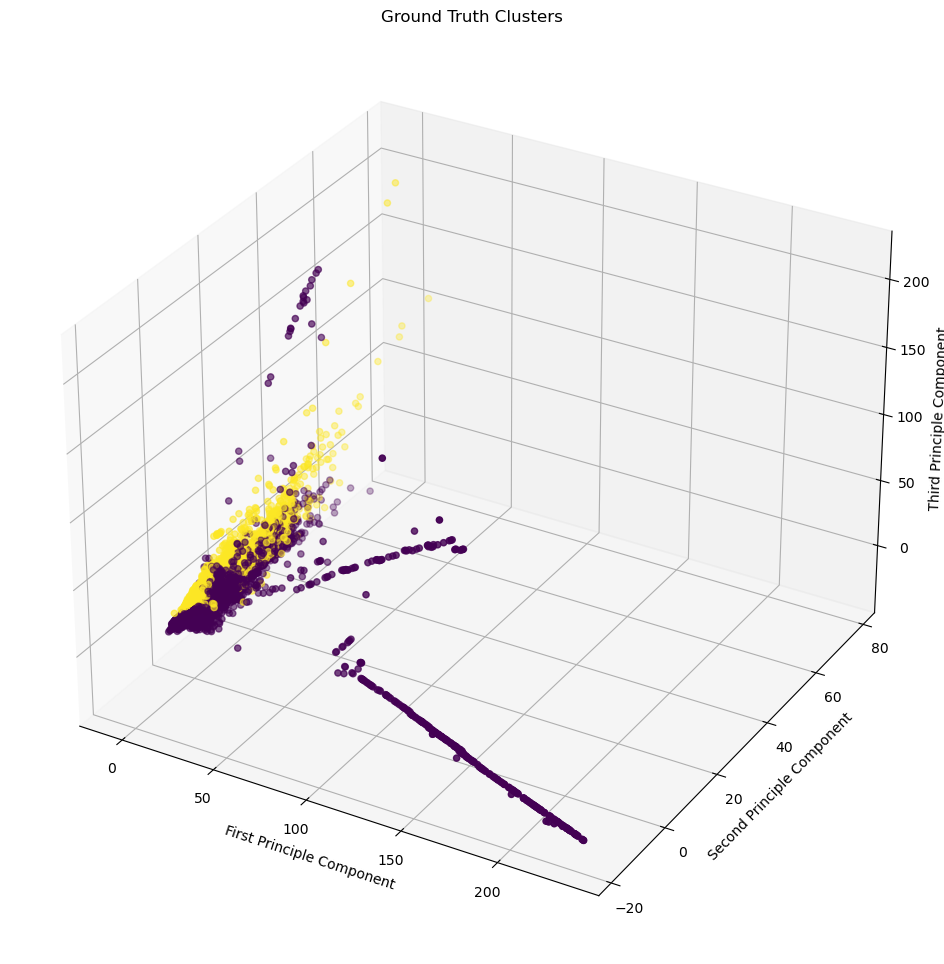

In [62]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(v_pca[:,0], v_pca[:,1], v_pca[:,2], c=y_test)
plt.xlabel("First Principle Component")
plt.ylabel("Second Principle Component")
ax.set_zlabel("Third Principle Component")
plt.title("Ground Truth Clusters")

plt.show()

## K-Means Visualization

Text(0.5, 0.92, 'Kmeans Clusters')

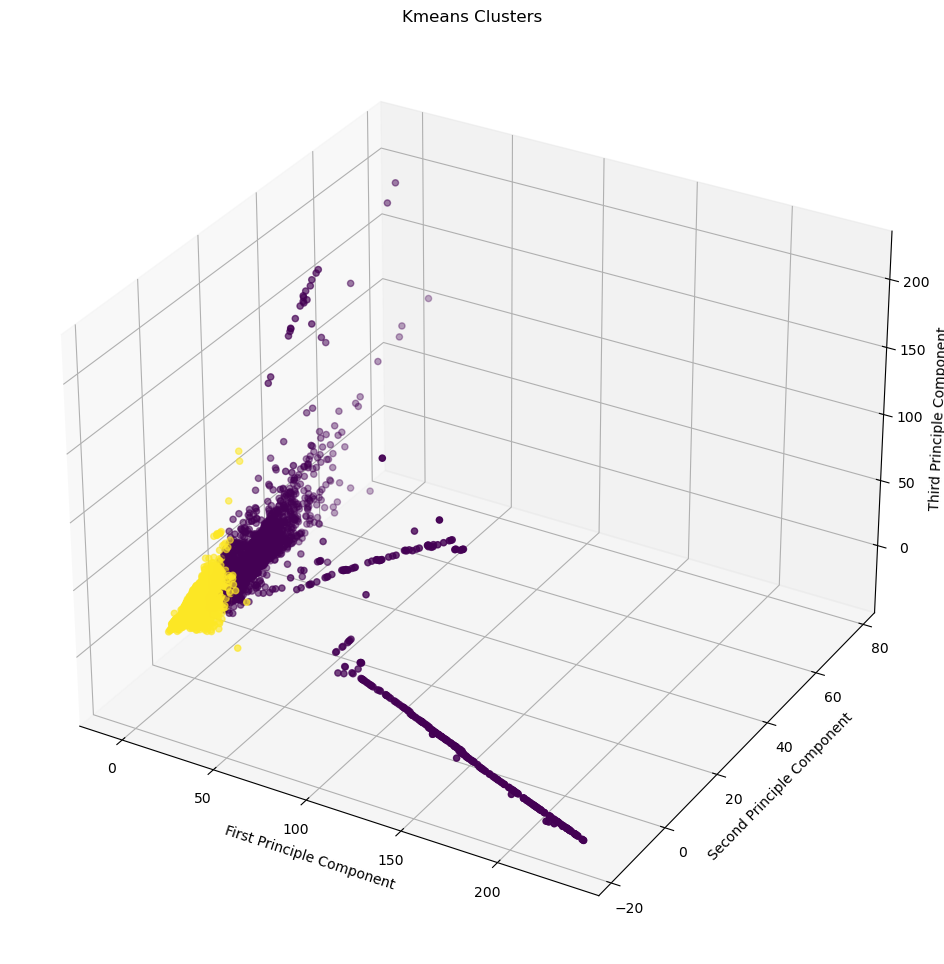

In [66]:
kmeans = KMeans(n_clusters=2, init='k-means++', n_init='auto').fit(v_pca)
kmeansY = kmeans.predict(v_pca)
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(v_pca[:,0], v_pca[:,1], v_pca[:,2], c=kmeansY)
plt.xlabel("First Principle Component")
plt.ylabel("Second Principle Component")
ax.set_zlabel("Third Principle Component")
plt.title("Kmeans Clusters")

## GMM=2 Data Visualization

Text(0.5, 0.92, 'GMM=2 Clusters')

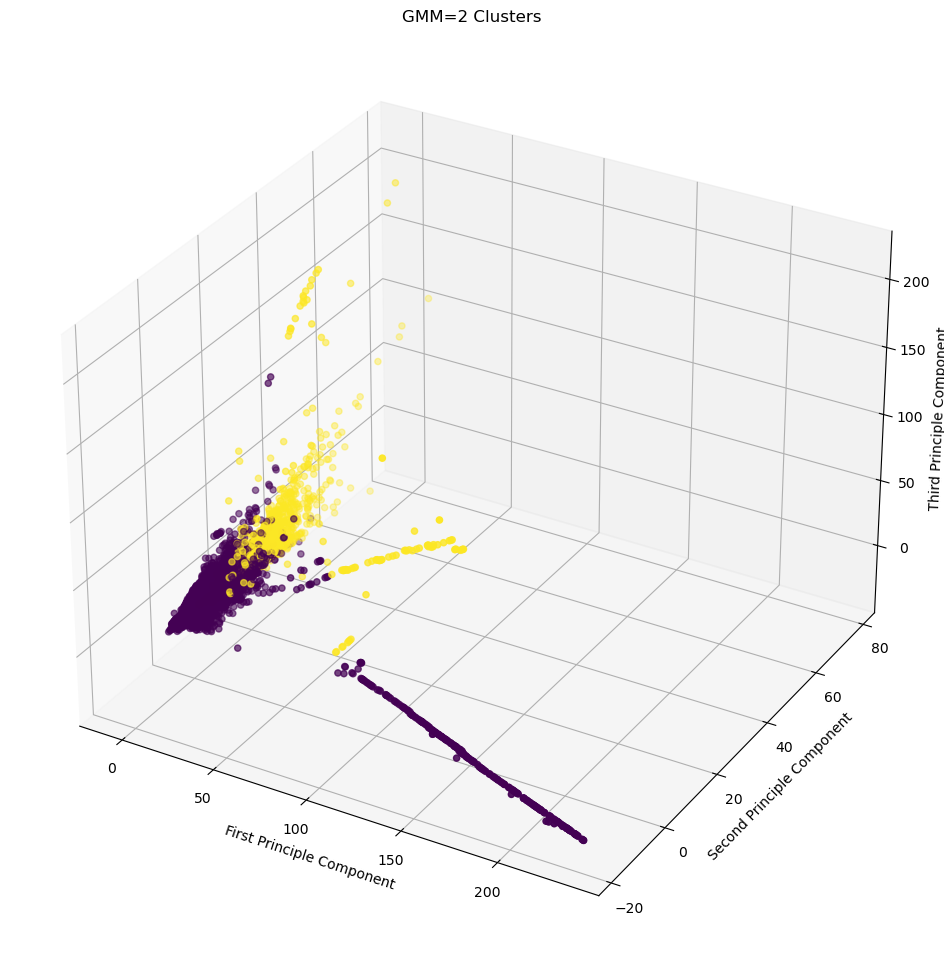

In [74]:
gmm2 = GaussianMixture(n_components=2, init_params='k-means++').fit(v_pca)
gmm2Y = gmm2.predict(v_pca)
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(v_pca[:,0], v_pca[:,1], v_pca[:,2], c=gmm2Y)
plt.xlabel("First Principle Component")
plt.ylabel("Second Principle Component")
ax.set_zlabel("Third Principle Component")
plt.title("GMM=2 Clusters")

## GMM=4 Data Visualization

Text(0.5, 0.92, 'GMM = 4 Assignments')

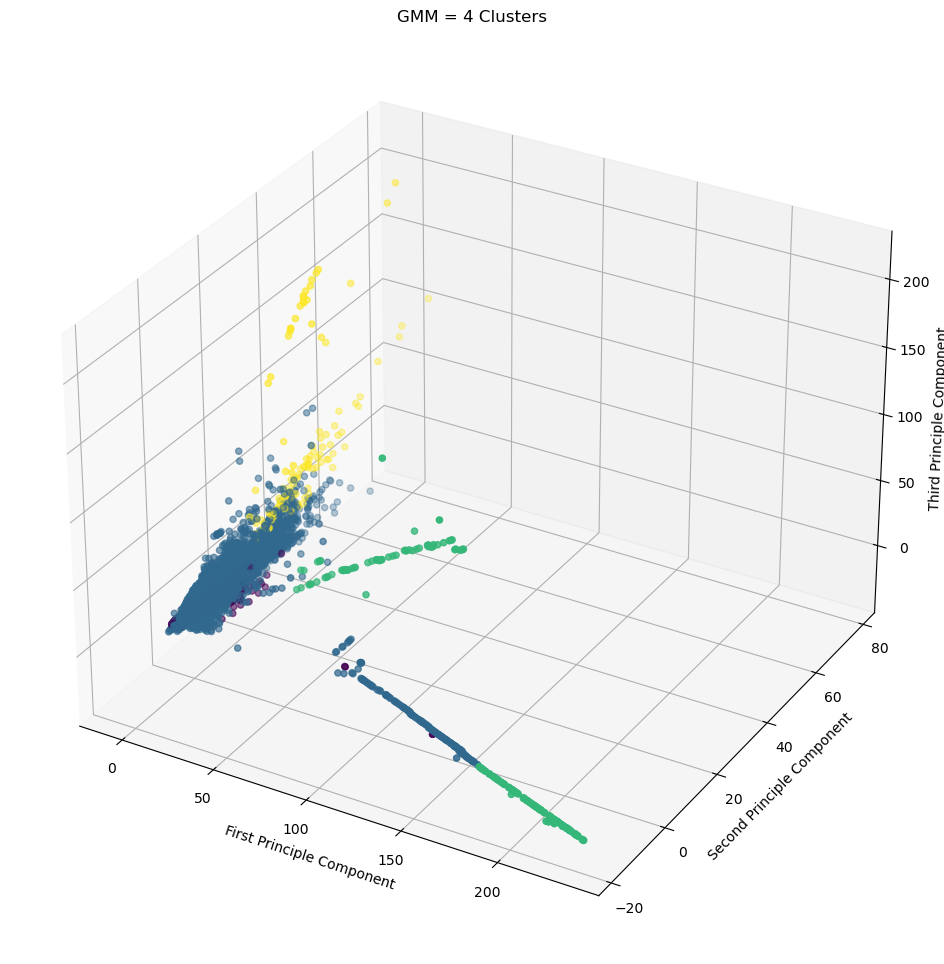

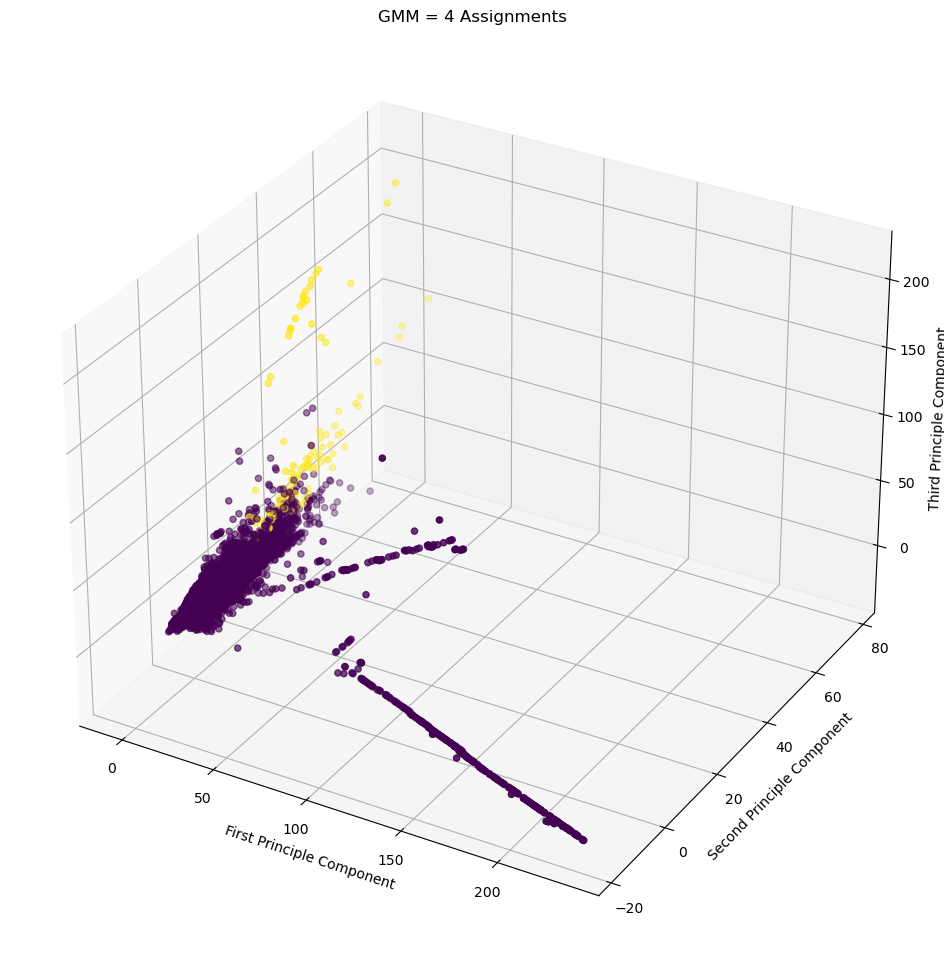

In [75]:
gmm4 = GaussianMixture(n_components=4, init_params='k-means++').fit(v_pca)
gmm4Y = gmm4.predict(v_pca)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(v_pca[:,0], v_pca[:,1], v_pca[:,2], c=gmm4Y)
plt.xlabel("First Principle Component")
plt.ylabel("Second Principle Component")
ax.set_zlabel("Third Principle Component")
plt.title("GMM = 4 Clusters")

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(v_pca[:,0], v_pca[:,1], v_pca[:,2], c=gmm4Y == getMaxCluster(gmm4Y))
plt.xlabel("First Principle Component")
plt.ylabel("Second Principle Component")
ax.set_zlabel("Third Principle Component")
plt.title("GMM = 4 Assignments")

# Summary of Results

## Kmeans

The data was cleaned with a k-nearest neighbors algorithm before being fitted to different models and subjected to principle component analysis. The data was then sent through a series of tests in which an increasing number of principle components were included. For each number of principle components considered, a k-means algorithm was ran 3 times with various data measures collected. The average results of the clustering evaluations was graphed and analyzed above. Over the various tests, the k-means algorithm had an average rand statistic of 0.41, an average balanced accuracy of 0.59, and an average recall of 0.79. These results show that the linear boundaries of k-means did not give a good reprisentation of the highly nonlinear data. The poor performance and lack of convergence of results implies that k-means is not capable of adequetly modeling the data.

## GMM

The data was prepared identically to k-means, and a similar battery of tests were ran with increasing numbers of principle components included. For the sake of rigor and completeness, a gaussian mixture of 2 components and 4 components were both tested. In a round of preliminary testing, the average log likelihoods of gaussian mixture models with various numbers of components were collected, and 4 clusters was identified as the best performer via the elbow method. The binary gaussian mixture had an average rand statistic of 0.54, an average balanced accuracy of 0.68, and an average recall of 0.82. The 4-component mixture had an average rand statistic of 0.85, an average balanced accuracy of 0.78, and an average recall of 0.71. Overall, the gaussian mixture models outperformed k-means, but the pairwise measures of both models did not show convergence. This fact, coupled with the unimpressive results, implies that the gaussian mixture model is still too simple to adequetly reprisent the data.